In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

In [7]:
#read the model
class EEGNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout2 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 1), stride=(2, 1))
        self.bn3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout3 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        # print('x:', x.shape)
        x = self.conv1(x)
        # print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # print('pool1:', x.shape)
        x = self.dropout1(x)
        x = self.conv2(x)
        # print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # print('pool2:', x.shape)
        x = self.dropout2(x)
        x = self.conv3(x)
        # print('conv3:',x.shape)
        x = self.bn3(x)
        # x = torch.relu(x)
        x = self.pool3(x)
        # print('pool3:',x.shape)
        x = x.view(x.size(0), -1)
        # print('flatten:', x.shape)
        x = self.fc1(x)
        # print('fc1:', x.shape)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        # print('fc2:', x.shape)
        return x
model = EEGNet()

In [8]:
import numpy as np

def sliding_window(signal, window_size, step_size):
    n_channels, n_samples = signal.shape
    n_windows = int((n_samples - window_size) / step_size) + 1
    windows = np.zeros((n_channels, window_size, n_windows))
    for i in range(n_windows):
        windows[:, :,i ] = signal.iloc[:, i*step_size:i*step_size+window_size]
    return windows

signal = pd.read_csv("C:\\Users\\a1882\Desktop\EEG\eegdata\\raw\lefthand_zyy_05_epocflex_2023.03.22t16.50.54+08.00.md.bp.csv")
signal = pd.DataFrame(signal)
# 定义滑窗大小和滑动步长
window_size = 128
step_size = 100

# 对信号进行滑窗处理
windows = sliding_window(signal, window_size, step_size)

# 输出滑窗后的信号形状
print("滑窗后信号形状：", windows.shape)
#print(windows)

滑窗后信号形状： (32, 128, 155)


In [9]:
save_path = 'C:\\Users\\a1882\Desktop\EEG\\normal\model\cnn_conv3_128_100e_97.pt'
model = EEGNet()
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()
for i in range(windows.shape[2]):
    signal = pd.DataFrame(windows[:,:,i])
    input = torch.from_numpy(signal.values)
    input = input.unsqueeze(0)
    output = model(input.float())

    # # print(output)
    # probabilities = torch.nn.functional.softmax(output, dim=1)
    # print(probabilities)

    _, pred = torch.max(output, dim=1)  # 找到预测分数最大的类别，得到预测类别
    label_map = {0: 'lefthand', 1:'read' ,  2:'rest', 3: 'walkbase', 4: 'walkl' ,5: 'walkfocus'}
    print(label_map[pred.item()])

rest
rest
rest
lefthand
lefthand
lefthand
rest
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
rest
lefthand
lefthand
rest
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
rest
lefthand
rest
lefthand
lefthand
rest
rest
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
lefthand
rest
lefthand


In [13]:
import torch
from matplotlib import pyplot as plt

def normalize_tensor(tensor):
    # Normalize the tensor along the channel dimension
    mean = tensor.mean(dim=(1,2), keepdim=True)
    std = tensor.std(dim=(1,2), keepdim=True)
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor

def show_normalized_tensor(tensor):
    # Normalize the tensor and convert it to a numpy array
    normalized_tensor = normalize_tensor(tensor)
    normalized_array = normalized_tensor.squeeze().numpy()

    # Display the normalized tensor using Matplotlib
    plt.imshow(normalized_array, cmap='seismic',aspect='auto')
    plt.axis('off')
    plt.savefig('for_cam.png')
    plt.show()

In [14]:
data = pd.read_csv("C:\\Users\\a1882\\Desktop\\EEG\\normal\\data\\128_s100\\lefthand_zyy_04_epocflex_2023_window_2.csv", header=None)
data = data.values
data = torch.from_numpy(data)
data = data.unsqueeze(0)
print(data.shape)

torch.Size([1, 32, 128])


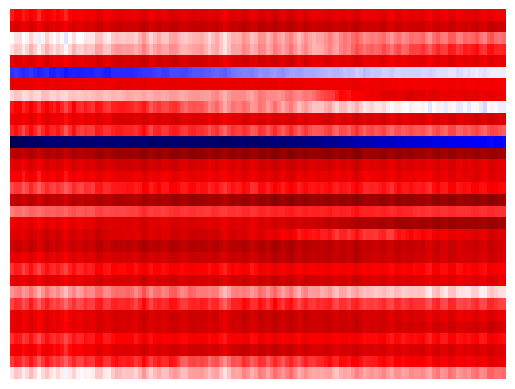

In [15]:
model = EEGNet()
input_tensor = data # example batch of input images
show_normalized_tensor(input_tensor)


In [20]:
# import numpy as np
# import torch
# import cv2
# import matplotlib.pyplot as plt
# import torchvision.models as models
# from torchvision.transforms import Compose, Normalize, ToTensor
#
# class GradCAM():
#     '''
#     Grad-cam: Visual explanations from deep networks via gradient-based localization
#     Selvaraju R R, Cogswell M, Das A, et al.
#     https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html
#     '''
#     def __init__(self, model, target_layers, use_cuda=False):
#         super(GradCAM).__init__()
#         self.use_cuda = use_cuda
#         self.model = model
#         self.target_layers = target_layers
#
#         self.target_layers.register_forward_hook(self.forward_hook)
#         self.target_layers.register_full_backward_hook(self.backward_hook)
#
#         self.activations = []
#         self.grads = []
#
#     def forward_hook(self, module, input, output):
#         self.activations.append(output[0])
#
#     def backward_hook(self, module, grad_input, grad_output):
#         self.grads.append(grad_output[0].detach())
#
#     def calculate_cam(self, model_input):
#         if self.use_cuda:
#             device = torch.device('cuda')
#             self.model.to(device)                 # Module.to() is in-place method
#             model_input = model_input.to(device)  # Tensor.to() is not a in-place method
#         self.model.eval()
#
#         # forward
#         y_hat = self.model(model_input)
#         max_class = np.argmax(y_hat.cpu().data.numpy(), axis=1)
#
#         # backward
#         model.zero_grad()
#         y_c = y_hat[0, max_class]
#         y_c.backward()
#
#         # get activations and gradients
#         activations = self.activations[0].cpu().data.numpy().squeeze()
#         grads = self.grads[0].cpu().data.numpy().squeeze()
#
#         # calculate weights
#         weights = np.mean(grads.reshape(grads.shape[0], -1), axis=1)
#         weights = weights.reshape(-1, 1, 1)
#         cam = (weights * activations).sum(axis=0)
#         cam = np.maximum(cam, 0) # ReLU
#         cam = cam / cam.max()
#         return cam
#
#     @staticmethod
#     def show_cam_on_image(image, cam):
#         # image: [H,W,C]
#         h, w = image.shape[:2]
#
#         cam = cv2.resize(cam, (h,w))
#         cam = cam / cam.max()
#         heatmap = cv2.applyColorMap((255*cam).astype(np.uint8), cv2.COLORMAP_JET) # [H,W,C]
#         heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
#
#         image = image / image.max()
#         heatmap = heatmap / heatmap.max()
#
#         result = 0.4*heatmap + 0.6*image
#         result = result / result.max()
#
#         plt.figure()
#         plt.imshow((result*255).astype(np.uint8))
#         plt.colorbar(shrink=0.8)
#         plt.tight_layout()
#         plt.show()
#
#     @staticmethod
#     def preprocess_image(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
#         preprocessing = Compose([
#         	ToTensor(),
#         	Normalize(mean=mean, std=std)
#             ])
#         return preprocessing(img.copy()).unsqueeze(0)
#
#
# if __name__ == '__main__':
#     image = cv2.imread('both.png') # (224,224,3)
#     input_tensor = GradCAM.preprocess_image(image)
#     # model = models.resnet18(pretrained=True)
#     model = EEGNet()
#     grad_cam = GradCAM(model, model.layer4[-1], 224)
#     cam = grad_cam.calculate_cam(input_tensor)
#     GradCAM.show_cam_on_image(image, cam)


In [21]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout2 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 1), stride=(2, 1))
        self.bn3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout3 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        features = x.clone()
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout4(x)
        output = self.fc2(x)
        return output, features


In [25]:
model = EEGNet()
model.load_state_dict(torch.load("C:\\Users\\a1882\Desktop\EEG\\normal\model\cnn_conv3_128_100e_97.pt"))
cam_generator = generate_cam(model, "conv3")
data = pd.read_csv("C:\\Users\\a1882\\Desktop\\EEG\\normal\\data\\128_s100\\lefthand_zyy_04_epocflex_2023_window_2.csv", header=None)
data = data.values
data = torch.from_numpy(data)
data = data.unsqueeze(0)
input_sample = data
target_class = 0
cam = cam_generator.generate_cam(input_sample, target_class)

TypeError: unsqueeze(): argument 'input' (position 1) must be Tensor, not str